In [1]:
# Need to scale problem better
# Need to include the cost function

In [2]:
%reset # clears variables in workspace

# import libraries
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition
import sympy as sym
import numpy as np
from IPython.display import display
from sympy import pprint

# import EOM
import dill
dill.load_session('simplified_biped.db')

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g] + [LL] +\
           [masses[base] for base in bases] +\
           [masses[link,leg] for leg in legs for link in links] +\
           [lengths[base] for base in bases] +\
           [lengths[link,leg] for leg in legs for link in links] +\
           [inertias[base] for base in bases] +\
           [inertias[link,leg] for leg in legs for link in links] +\
           [x_body]+[y_body]+[th_body] + [th[link,leg] for leg in legs for link in links if 'foot' not in link] +\
           [dx_body]+[dy_body]+[dth_body] + [dth[link,leg] for leg in legs for link in links if 'foot' not in link] +\
           [ddx_body]+[ddy_body]+[ddth_body] + [ddth[link,leg] for leg in legs for link in links if 'foot' not in link] +\
           [tau['left',leg] for leg in legs] + [tau['right',leg] for leg in legs] +\
           [lamda['x',leg] for leg in legs] + [lamda['y',leg] for leg in legs] +\
           [GRF['x',leg] for leg in legs] + [GRF['y',leg] for leg in legs]

lamb_EOMs = {}

DOFs = ['x_body'] + ['y_body'] +['theta_body']

for leg in legs:
    for link in links:
        if 'foot' not in link:
            DOFs = DOFs + ['theta_{0}'.format(link+leg)]

for dof_i,dof in enumerate(DOFs):
    lamb_EOMs.update({dof: sym.lambdify(sym_list,EOMs[dof_i],modules = [func_map])})

    
# PARAMETERS:
masses_ = {'body': 5756.78/1000,
           'ullA': 153.81/1000,
           'lllA': 346.45/1000,
           'urlA': 153.81/1000,
           'lrlA': 346.45/1000,
           'ullB': 153.81/1000,
           'lllB': 346.45/1000,
           'urlB': 153.81/1000,
           'lrlB': 346.45/1000}

lengths_ = {'body': 24/100,
            'ullA': 17.5/100,
            'lllA': 30.0/100,
            'urlA': 17.5/100,
            'lrlA': 30.0/100,
            'ullB': 17.5/100,
            'lllB': 30.0/100,
            'urlB': 17.5/100,
            'lrlB': 30.0/100}

''' ****** '''
inertias_ = {'body': 32124078.52*1e-9, # body rotate about its center 
            'ullA': 600933.68*1e-9, # rotates as pendulumn 
            'urlA': 600933.68*1e-9,
            'lllA': 4659658.63*1e-9,
            'lrlA': 4659658.63*1e-9,
            'ullB': 600933.68*1e-9, # rotates as pendulumn 
            'urlB': 600933.68*1e-9,
            'lllB': 4659658.63*1e-9,
            'lrlB': 4659658.63*1e-9}

total_mass = 0.0
for mass in masses_:
    total_mass += masses_[mass]
total_mass

WDOFs = ['X','Y'] 
signs = ['-ve','+ve'] 
legs = ['A','B']
links = ['ull','lll','url','lrl']
bases = ['body']
ground_constraints = ['contact','friction','slip_+ve','slip_-ve'] # Group all constraints occuring at the ground
sides = ['left','right']
coordinates = {'X':0 , 'Y':1}
motor_w_angle = {'left': 'ull' ,'right': 'url'}
all_links = []
for leg in legs:
    for link in links:
        all_links.append(link+leg)
        
[all_links.append(base) for base in bases]

def get_var_list_zeros(m,n):
    var_list = [m.g] + [m.LL] +\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias[base] for base in bases] +\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs]
    return var_list

def get_var_list_values(m,n):
    
    BW = 1
    tau_value = {}
    connection_force_value = {}
    GRF_X_value = {}
    GRF_Y_value = {}
    
    for leg in legs:
        
        [tau_value.update({(side,leg): BW*(m.tau_torque[n,side,leg])}) for side in sides]
        #[connection_force_value.update({(wdof,leg):BW*(m.connect_force[n,'+ve',wdof,leg]-m.connect_force[n,'-ve',wdof,leg])}) for wdof in WDOFs]
        #[connection_force_value.update({(wdof,leg):0.0})for wdof in WDOFs]
        [connection_force_value.update({(wdof,leg):BW*(m.connect_force[n,wdof,leg])}) for wdof in WDOFs]
        GRF_X_value.update({(leg):BW*(m.GRF_x[n,'+ve',leg]-m.GRF_x[n,'-ve',leg])})
        GRF_Y_value.update({(leg):BW*(m.GRF_y[n,leg])})

    var_list = [m.g] + [m.LL] +\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias[base] for base in bases] +\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [tau_value['left',leg] for leg in legs] + [tau_value['right',leg] for leg in legs] +\
               [connection_force_value['X',leg] for leg in legs] + [connection_force_value['Y',leg] for leg in legs] +\
               [GRF_X_value[leg] for leg in legs] + [GRF_Y_value[leg] for leg in legs]
    return var_list



Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  clears, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
Flushing input history
Don't know how to reset  workspace, please run `%reset?` for details


--------------
Stall torque =  140.4238410596027
Max speed =  55.8
--------------


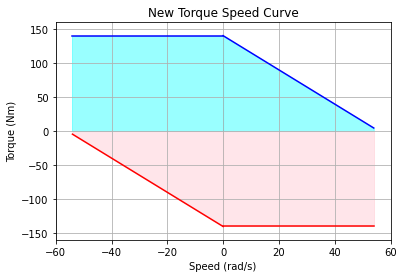

In [3]:
'''Plot Torque Speed Curve'''
import matplotlib.pyplot as plt
x_p = np.linspace(0, 54, num=54)
x_n = np.linspace(-54, 0, num=54)
no_load_speed = 55.8
# from graph
max_torque = 38.0
speed_max_torque = 40.7

m_grad = (max_torque-0.0)/(speed_max_torque-no_load_speed)

stall_torque = 0.0 - m_grad*no_load_speed

y_p = m_grad*x_p+stall_torque
y_n = m_grad*x_n-stall_torque

max_torque_p = []
max_torque_n = []

for ii in range(len(x_p)):
    max_torque_p.append(stall_torque)
    max_torque_n.append(-stall_torque)

plt.grid()
plt.plot(x_p, y_p,'b')
plt.plot(x_n, max_torque_p,'b')

plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
plt.fill_between(x_n, max_torque_p, alpha=0.4,color = 'cyan')

plt.plot(x_n, y_n,'r')
plt.plot(x_p, max_torque_n,'r')

plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
plt.fill_between(x_p, max_torque_n, alpha=0.4,color = 'pink')

plt.axis((-60,60,-160,160))
plt.title('New Torque Speed Curve')
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')
print('--------------')

print('Stall torque = ',stall_torque)
print('Max speed = ',no_load_speed)

print('--------------')

In [4]:
tests = {0:"High_Drop_Test",1:"Low_Drop_Test", 2:"Hop_Test", 3:"Drop_Hop_Test",\
         4:"Standing_Test", 5:"Tax_Day_Sprint",6:"Missing_the_Boat",\
         7:"Periodic_Hop",8:"Periodic_Run",9:"Stop_Periodic_Run",10:"Start_Periodic_Run",\
         11:"High_Drop_Move_Leg", 12:"Forward_Hop"}

test = tests[8]
V_avg = 1.0
if test == "High_Drop_Test" or test == "Low_Drop_Test" or test == "Standing_Test":
    N = 50
    TT = 0.2
elif test == "High_Drop_Move_Leg":
    N = 50
    TT = 0.4
elif test == "Forward_Hop":
    N = 50
    TT = 0.7
    x_final = 2.0 # for display
elif test == "Hop_Test" or test == "Drop_Hop_Test":
    N = 50
    TT = 1.0
elif test == "Tax_Day_Sprint":
    N = 50
    TT = 1.5
    x_final = 5.0
elif test == "Missing_the_Boat":
    N = 50
    TT = 1.0
    x_final = 5.0
elif test == "Periodic_Hop":
    N = 50
    TT = 1.0 # 2Hz but only half a gait due to symmetry
    dy_periodic = 0.5
elif test == "Periodic_Run":
    N = 50
    TT = 0.3 # 2Hz but only half a gait due to symmetry
    V_flight = 0.75*sqrt(9.81*(0.18+0.35)) # from paper
    x_final = 3.0 # for display
elif test == "Stop_Periodic_Run" or test == "Start_Periodic_Run":
    import csv
    file = open(str(round(V_avg))+'.csv')
    csvreader = csv.reader(file)
    rows = []
    for row in csvreader:
        rows.append(row)
    initial_conditions = {}
    for item in rows:
        initial_conditions[item[0]] = float(item[1])
    x_final = 5.0 # for display 
    if test == "Stop_Periodic_Run":
        N = 50
        TT = 0.8 # 2Hz but only half a gait due to symmetry
    elif test == "Start_Periodic_Run":
        N = 50
        TT = 1.0
    else: pass   
    
else:
    N = 50
    TT = 0.5

In [5]:
print("total mass = " ,total_mass)
print("test = ",test)

total mass =  7.75782
test =  Periodic_Run


<a id='time_step'></a>

In [6]:
m = ConcreteModel('Biped')

#SETS-------------------------
m.N = RangeSet(N)
m.ground_constraints = Set(initialize = ground_constraints)
m.legs = Set(initialize = legs)
m.links = Set(initialize = links)
m.bases = Set(initialize = bases)
m.all_links = Set(initialize = all_links)
m.DOFs = Set(initialize = DOFs)
m.WDOFs = Set(initialize = WDOFs)
m.signs = Set(initialize = signs)
m.sides = Set(initialize = sides)


#Params--------------------------
m.g = Param(initialize = 9.81)
m.LL = Param(initialize = 7.5/100)

# m.masses = Param(m.links, initialize = masses)
m.masses = Param(m.all_links, initialize = masses_)
m.lengths = Param(m.all_links, initialize = lengths_)
m.inertias = Param(m.all_links, initialize = inertias_)


#VARIABLES----------------------
#gen coordinates
m.q = Var(m.N,m.DOFs)
m.dq = Var(m.N,m.DOFs)
m.ddq = Var(m.N,m.DOFs)

In [7]:
''' CONSTRAINTS  - Integration'''

# variable timestep
hm = TT/N # master timestep
m.h = Var(m.N, bounds = (0.8,1.2))

def BwEuler_p(m,n,dof):
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip
m.integrate_p = Constraint(m.N, m.DOFs, rule = BwEuler_p)

def BwEuler_v(m,n,dof):
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOFs, rule = BwEuler_v)

In [8]:
# ''' CONSTRAINTS  - CONNECTION POINT'''
# m.connect_position = Var(m.N, m.WDOFs, m.sides, m.legs) # connection point
# m.connect_force = Var(m.N, m.signs, m.WDOFs, m.legs, bounds = (0.0,None)) # connection force

# # Lamdify
# lamb_connect_position = {} # (WDOFs,sides,leg)
# [lamb_connect_position.update({(wdof,side,leg): sym.lambdify(sym_list,connect_foot_position[side,leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for side in sides for wdof in WDOFs]

# # Equate the connection equations from the previous script to the model m
# def def_connect_position_equation(m,n,wdof,side,leg):
#     var_list = get_var_list_zeros(m,n)    
#     return m.connect_position[n,wdof,side,leg] == lamb_connect_position[wdof,side,leg](*var_list)
# m.connect_position_equation = Constraint(m.N, m.WDOFs, m.sides, m.legs, rule = def_connect_position_equation)

# # Ensure that there is no distance between the X (and Y) of link connection points
# def def_connect_position(m,n,wdof,leg):
#     return  m.connect_position[n,wdof,'right',leg] - m.connect_position[n,wdof,'left',leg] == 0.0
# m.connect_position_constraint = Constraint(m.N, m.WDOFs, m.legs, rule= def_connect_position)

In [9]:
''' CONSTRAINTS  - CONNECTION POINT'''
m.connect_position = Var(m.N, m.WDOFs, m.sides, m.legs) # connection point
m.connect_force = Var(m.N, m.WDOFs, m.legs,bounds = (-10*total_mass*9.81,10*total_mass*9.81)) # connection force

# Lamdify
lamb_connect_position = {} # (WDOFs,sides,leg)
[lamb_connect_position.update({(wdof,side,leg): sym.lambdify(sym_list,connect_foot_position[side,leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for side in sides for wdof in WDOFs]

# Equate the connection equations from the previous script to the model m
def def_connect_position_equation(m,n,wdof,side,leg):
    var_list = get_var_list_zeros(m,n)    
    return m.connect_position[n,wdof,side,leg] == lamb_connect_position[wdof,side,leg](*var_list)
m.connect_position_equation = Constraint(m.N, m.WDOFs, m.sides, m.legs, rule = def_connect_position_equation)

# Ensure that there is no distance between the X (and Y) of link connection points
def def_connect_position(m,n,wdof,leg):
    return  m.connect_position[n,wdof,'right',leg] - m.connect_position[n,wdof,'left',leg] == 0.0
m.connect_position_constraint = Constraint(m.N, m.WDOFs, m.legs, rule= def_connect_position)

In [10]:
#Variable of foot position
m.foot_position = Var(m.N, m.WDOFs, m.legs)
for n in range(1,N+1):
    for leg in legs:
        m.foot_position[n,'Y',leg].setlb(0.0)

#Get the foot position in WDOF
lamb_foot_position = {}
[lamb_foot_position.update({(wdof,leg): sym.lambdify(sym_list,connect_foot_position['right',leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for wdof in WDOFs]

def def_foot_position(m,n,wdof,leg):
    var_list = get_var_list_zeros(m,n)
    return m.foot_position[n,wdof,leg] == lamb_foot_position[wdof,leg](*var_list)
m.def_foot_position = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_position)

m.mu = Param(initialize = 1,within=Any)

# Variables
m.foot_velocity = Var(m.N, m.WDOFs, m.signs, m.legs, bounds = (0.0,None)) # the sign will account for -ve velocities
m.friction_cone = Var(m.N, m.legs, bounds = (0.0,None)) 
m.GRF_y = Var(m.N, m.legs, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces
m.GRF_x = Var(m.N, m.signs, m.legs, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces

'''******'''
m.ground_penalty = Var(m.N, m.ground_constraints, m.legs, bounds = (0.0,10.0)) # penalty

lamb_foot_velocity_x = {}

# Get the foot position in WDOF
[lamb_foot_velocity_x.update({(leg): sym.lambdify(sym_list,(connect_foot_position['right',leg].jacobian(q)*dq)[0].simplify(),modules = [func_map])}) for leg in legs]

# CONSTRAINTS
def def_foot_velocity(m,n,wdof,leg):
    if wdof == 'X':
        var_list = get_var_list_zeros(m,n)
        return m.foot_velocity[n,'X','+ve',leg]-m.foot_velocity[n,'X','-ve',leg] == lamb_foot_velocity_x[leg](*var_list)
    else: return Constraint.Skip
m.foot_velocity_constraint = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_velocity)

def def_friction_cone(m,n,leg):
    return m.friction_cone[n,leg] == m.mu*m.GRF_y[n,leg] - (m.GRF_x[n,'+ve',leg] + m.GRF_x[n,'-ve',leg])
m.friction_cone_constraint = Constraint(m.N, m.legs, rule = def_friction_cone)

# constraints: complementarity

# contact
def def_ground_contact(m,n,leg):
    if n < N:
        return m.foot_position[n+1,'Y',leg]*m.GRF_y[n,leg] <= m.ground_penalty[n,'contact',leg]
    else:
        return Constraint.Skip
m.ground_contact_constraint = Constraint(m.N, m.legs, rule = def_ground_contact)

# friction
def def_ground_friction(m,n,leg):
    return (m.foot_velocity[n,'X','+ve',leg]+m.foot_velocity[n,'X','-ve',leg])*m.friction_cone[n,leg] <= m.ground_penalty[n,'friction',leg]
m.ground_friction_constraint = Constraint(m.N, m.legs, rule = def_ground_friction)

# slipping
def def_ground_slip_positive(m,n,leg):
    return m.foot_velocity[n,'X','+ve',leg]*m.GRF_x[n,'+ve',leg] <= m.ground_penalty[n,'slip_+ve',leg]
m.ground_slip_positive_constraint = Constraint(m.N, m.legs, rule = def_ground_slip_positive)

def def_ground_slip_negative(m,n,leg):
    return m.foot_velocity[n,'X','-ve',leg]*m.GRF_x[n,'-ve',leg] <= m.ground_penalty[n,'slip_-ve',leg]
m.ground_slip_negative_constraint = Constraint(m.N, m.legs, rule = def_ground_slip_negative)

#bound contact forces at last node
for leg in legs:
    m.GRF_y[N,leg].fix(0.0)
    for sgn in signs:
        m.GRF_x[N,sgn,leg].fix(0.0)


KeyboardInterrupt: 

In [ ]:
'''Torque Speed - Speed Torque Curve'''

m.tau_torque = Var(m.N, m.sides, m.legs, bounds = (-max_torque,max_torque))
m.tau_velocity = Var(m.N, m.sides, m.legs, bounds = (-no_load_speed,no_load_speed))

lamb_tau_velocity = {}
[lamb_tau_velocity.update({(side,leg): sym.lambdify(sym_list,w_links[motor_w_angle[side],leg],modules = [func_map])}) for leg in legs for side in sides]

def def_angular_velocity(m,n,side,leg):
    var_list = get_var_list_zeros(m,n)
    return m.tau_velocity[n,side,leg] == lamb_tau_velocity[side,leg](*var_list)
m.left_angular_velocity_constraint = Constraint(m.N, m.sides, m.legs, rule = def_angular_velocity)

# assume straight line
def def_constant_power_right(m,n,side,leg):
    return m.tau_torque[n,side,leg] <= m.tau_velocity[n,side,leg]*m_grad + stall_torque
m.constant_power_right_constraint = Constraint(m.N, m.sides, m.legs, rule = def_constant_power_right)

def def_constant_power_left(m,n,side,leg):
    return m.tau_torque[n,side,leg] >= m.tau_velocity[n,side,leg]*m_grad - stall_torque
m.constant_power_left_constraint = Constraint(m.N, m.sides, m.legs, rule = def_constant_power_left)

In [ ]:
# Set the angles for the knees - only use this when actuated 
# This ensures links does not cross
m.knee_angle = Var(m.N, m.sides, m.legs, bounds = (0.0,170*(np.pi)/180))

def def_knee_angle(m,n,side,leg):
    if side == 'left':
        return m.knee_angle[n,side,leg] == 2*np.pi - m.q[n,'theta_lll'+leg]
    else:
        return m.knee_angle[n,side,leg] == m.q[n,'theta_lrl'+leg]   
m.knee_angle_constraint = Constraint(m.N, m.sides, m.legs, rule = def_knee_angle)

In [ ]:
# Get the foot position in WDOF
if test == "Periodic_Run" or test == "Periodic_Hop":
    
    lamb_body_position_x = sym.lambdify(sym_list,(r_bases['body'])[0].simplify(),modules = [func_map])
    m.body_position = Var(m.N, m.WDOFs) # the sign will account for -ve velocities

    # CONSTRAINTS
    def def_body_position(m,n,wdof):
        var_list = get_var_list_zeros(m,n)
        if wdof == 'X':
            return m.body_position[n,'X'] == lamb_body_position_x(*var_list)
        else: return Constraint.Skip
    m.body_position_constraint = Constraint(m.N, m.WDOFs, rule = def_body_position)
    
    
    if test == "Periodic_Run":
        
        # Average velocities
        def def_body_position_average(m,wdof):
            if wdof == 'X':
                return (m.body_position[N,'X'] - m.body_position[1,'X'])/(sum(hm*m.h[n] for n in range(1,N+1))) == V_avg
            else: return Constraint.Skip
        m.def_body_position_average_constraint = Constraint(m.WDOFs, rule = def_body_position_average)
        
        # Equate states
        def def_equate_position_states(m,n,dof_i):
            if dof_i == 'y_body' or dof_i == 'theta_body':
                return m.q[1,dof_i] == m.q[N,dof_i]
            
            elif dof_i == 'theta_ullA':
                return m.q[1,'theta_ullA'] == m.q[N,'theta_ullB']
            elif dof_i == 'theta_ullB':
                return m.q[1,'theta_ullB'] == m.q[N,'theta_ullA']
            
            elif dof_i == 'theta_urlA':
                return m.q[1,'theta_urlA'] == m.q[N,'theta_urlB']
            elif dof_i == 'theta_urlB':
                return m.q[1,'theta_urlB'] == m.q[N,'theta_urlA']
            
            elif dof_i == 'theta_lllA':
                return m.q[1,'theta_lllA'] == m.q[N,'theta_lllB']
            elif dof_i == 'theta_lllB':
                return m.q[1,'theta_lllB'] == m.q[N,'theta_lllA']
            
            elif dof_i == 'theta_lrlA':
                return m.q[1,'theta_lrlA'] == m.q[N,'theta_lrlB']
            elif dof_i == 'theta_lrlB':
                return m.q[1,'theta_lrlB'] == m.q[N,'theta_lrlA']
            else: 
                 return Constraint.Skip
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs, rule = def_equate_position_states) 

        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)
  
    
        # Condition where the GRF can't increase twice from zero          
    
    
    else: 
        
        def def_equate_position_states(m,n,dof_i):
            return m.q[1,dof_i] == m.q[N,dof_i]
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_position_states)
        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)

else: pass
                                    


In [ ]:
''' Use this code for tests '''

# BOUND VALUES
sign_symbols = ['+','-']
boundaries = ['setub','setlb']
for n in range(1,N+1):
    for leg in legs:
        for index in range(len(boundaries)):
            eval('m.q[n,\'theta_ull\'+leg].{0}(np.pi*(0.5{1}1/2))'.format(boundaries[index],sign_symbols[index]))
            eval('m.q[n,\'theta_lll\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))  
            eval('m.q[n,\'theta_url\'+leg].{0}(np.pi*(0.5{1}1/2))'.format(boundaries[index],sign_symbols[index]))    
            eval('m.q[n,\'theta_lrl\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))

    m.q[n,'theta_body'].setub(np.pi*(1/4))
    m.q[n,'theta_body'].setlb(np.pi*(-1/4))
        
    if test == "Periodic_Run":
        m.q[n,'y_body'].setub(1.0)
        m.dq[1,'y_body'].fix(0.0)
        
#         m.dq[1,'theta_UL'].fix(0.0)
#         m.dq[1,'theta_UR'].fix(0.0)
        
    elif test == "Periodic_Hop":
        m.dq[1,'y_body'].fix(0.0)       
    
    else:
        if test == "Forward_Hop":
            m.q[n,'y_body'].setub(2.0)
        else: pass
        for dof in DOFs:
            m.dq[1,dof].fix(0.0)
    
    if test == "High_Drop_Test" or test == "Low_Drop_Test" or test == "Standing_Test" or test == "Drop_Hop_Test" or test =="Periodic_Hop" or test == "High_Drop_Move_Leg":

        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = 1.0
        y_low_lim = -0.5
        y_high_lim = 2.0
        
    
        if test == "Drop_Hop_Test" or test == "Periodic_Hop" or test == "High_Drop_Move_Leg":
            
            [m.tau_torque[1,side,leg].fix(0.0) for side in sides for leg in legs]
            
        else:
            
            [m.tau_torque[n,side,leg].fix(0.0) for side in sides for leg in legs]
    else:
    
        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = x_final + 1.0
        y_low_lim = -0.5
        y_high_lim = 1.5
    
        if test == "Periodic_Run":
            pass
        else:
            [m.tau_torque[1,side,leg].fix(0.0) for side in sides for leg in legs]

<a id='initial_conditions'></a>

In [ ]:
if test == "High_Drop_Test":
    #  ----------------------------- HIGH DROP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))

    m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

    m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/10))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/10))
        
elif test == "High_Drop_Move_Leg":
    #  ----------------------------- HIGH DROP MOVE LEG TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))

    m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

    m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/10))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/10))
    
    m.foot_position[N, 'X', 'A'].fix(0.1)
    m.foot_position[N, 'X', 'B'].fix(-0.1)
    
elif test == "Forward_Hop":
    #  ----------------------------- FORWARD HOP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))

    m.foot_position[1, 'X', 'A'].fix(0.0)
    m.foot_position[1, 'X', 'B'].fix(0.0)
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)

    m.q[N,'x_body'].setlb(1.5)
    
elif test == "Low_Drop_Test":
    #  ----------------------------- LOW DROP TEST ---------------------------

    # initial condition

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.foot_position[1, 'Y', 'A'].fix(0.12)
    m.foot_position[1, 'Y', 'B'].fix(0.12)

    m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

    m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/7))

        
elif test == "Hop_Test":
    #  ----------------------------- HOP TEST ---------------------------

    # initial condition
    m.q[1,'y_body'].fix(0.35)
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)
    m.foot_position[1, 'X', 'A'].fix(0.0)
    m.foot_position[1, 'X', 'B'].fix(0.0)
        
    m.q[N,'y_body'].setlb(0.8)

elif test == "Drop_Hop_Test":
    
    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    
#     m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
#     m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

#     m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/7))
#     m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/7))
        
    m.foot_position[round(N/5), 'Y', 'A'].setub(0.05)
    m.foot_position[round(N/5), 'Y', 'B'].setub(0.05)
        
    m.q[N,'y_body'].setlb(0.8)
    m.q[N,'x_body'].setub(0.7)
    m.q[N,'x_body'].setlb(0.3)
    
elif test == "Standing_Test":
    
    # initial condition
    m.q[1,'x_body'].fix(0.5)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
 
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)
     
    m.foot_position[N, 'Y', 'A'].fix(0.0)
    m.foot_position[N, 'Y', 'B'].fix(0.0)
    
elif test == 'Tax_Day_Sprint':
    
    # INITIALIZE ----------------------------------------------------------------------------------------------------------------
    guide = np.linspace(0,x_final,N)
    for n in range(1,N+1):
        m.GRF_y[n,'A'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','A'].value = m.mu.value*m.GRF_y[n,'A'].value
        m.GRF_y[n,'B'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','B'].value = m.mu.value*m.GRF_y[n,'B'].value
        
#         m.q[n,'x'].value = guide[n-1] + np.random.uniform(-0.25,0.25)
#         m.q[n,'y'].value  = np.random.uniform(0.5,1.1)
#         m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/8,np.pi/8)
#         m.q[n,'theta_l'].value  = np.random.uniform(-np.pi/4,np.pi/4)
#         m.q[n,'r'].value  = np.random.uniform(0.0,0.5)
        
    # SPRINT --------------------------------------------------------------------------------------------------------------------
    # tax day

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    
    m.q[1,'theta_ullA'].fix(np.pi*(0.5))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5))
    m.q[1,'theta_ullB'].fix(np.pi*(0.5))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5))
        
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)

    # final condition
    m.q[N,'x_body'].setlb(x_final)

    m.dq[N,'x_body'].fix(0.0)
    m.dq[N,'theta_body'].fix(0.0)
    
    m.dq[N,'theta_ullA'].fix(0.0)
    m.dq[N,'theta_urlA'].fix(0.0)
    m.dq[N,'theta_ullB'].fix(0.0)
    m.dq[N,'theta_urlB'].fix(0.0)

    m.q[N,'theta_body'].fix(0.0)

    m.foot_position[N, 'Y', 'A'].fix(0.0)
    m.foot_position[N, 'Y', 'B'].fix(0.0)

    #m.pprint()
    
elif test ==  "Missing_the_Boat":
    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)
    m.q[N,'x_body'].setlb(x_final)

elif test == "Periodic_Hop":
    m.q[1,'y_body'].fix(1.0) # initial condition  
    m.q[1,'x_body'].fix(0.0) # initial condition  
    
    m.q[1,'theta_UL'].fix(0.0)
    m.q[1,'theta_UR'].fix(0.0)
    
    m.dq[1,'theta_UL'].fix(0.0)
    m.dq[1,'theta_UR'].fix(0.0)
    m.dq[1,'{r_prismatic}_{footL}'].fix(0.0)
    m.dq[1,'{r_prismatic}_{footR}'].fix(0.0)
    
    m.dq[N,'y_body'].fix(0.0) # initial condition
    

elif test == "Periodic_Run":
    # INITIALIZE ----------------------------------------------------------------------------------------------------------------
    guide = np.linspace(0,TT*V_avg,N)
    for n in range(1,N+1):
        m.q[n,'x_body'].value = guide[n-1] #+ np.random.uniform(-0.25,0.25)
#         m.q[n,'y'].value  = np.random.uniform(0.5,1.1)
#         m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/8,np.pi/8)
#         m.q[n,'theta_l'].value  = np.random.uniform(-np.pi/4,np.pi/4)
#         m.q[n,'r'].value  = np.random.uniform(0.0,0.5)

#         m.GRF[n,'Y','ps'].value = np.random.uniform(0.0,1)
#         m.GRF[n,'X','ps'].value = m.mu.value*m.GRF[n,'Y','ps'].value
        

    m.q[1,'x_body'].fix(0.0) # initial condition
    m.q[1,'theta_body'].fix(0.0)
    
    m.q[1,'theta_ullA'].setlb(np.pi*(0.5-1/6))
    m.q[1,'theta_urlA'].setub(np.pi*(0.5+1/6))
    
    m.q[1,'theta_urlB'].setlb(np.pi*(0.5-1/6))
    m.q[1,'theta_ullB'].setub(np.pi*(0.5+1/6))
    
    
    for n in range(1,N+1):
        m.GRF_y[n,'A'].fix(0.0)
        m.foot_position[n, 'Y', 'A'].setlb(0.05)
    
    m.GRF_y[1,'B'].fix(0.0)
    
    
    
    
#     """ ******** CANNOT CHANGE ORDER OF phases ********* """
#     phases = ['flight','stance']
    
#     phase_times = {}
       
#     phase_times.update({('left','flight'): 25})
#     phase_times.update({('left','stance'): 25})
#     phase_times.update({('right','flight'): 25})
#     phase_times.update({('right','stance'): 25})
    
#     timing_diagram = {}
#     timer = 0
    
#     for side in sides:
#         for phase in phases:
#             timer = timer + round(N*(phase_times[side,phase]/100))
#             timing_diagram.update({(side,phase): timer})
    
#     min_height = 0.005
#     min_GRF = 0.05
    
#     for left_flight in range (1,timing_diagram['left','flight']+1):
#         m.GRF_y[left_flight,'footL'].fix(0.0)
#         m.GRF_y[left_flight,'footR'].fix(0.0)
#         m.foot_position[left_flight, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_flight, 'Y', 'footL'].setlb(min_height)
        
#     for left_stance in range (timing_diagram['left','flight']+1,timing_diagram['left','stance']+1):
#         # left foot down
#         m.GRF_y[left_stance,'footR'].fix(0.0)
#         m.foot_position[left_stance, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_stance, 'Y', 'footL'].fix(0.0)
        
#     for right_flight in range (timing_diagram['left','stance']+1,timing_diagram['right','flight']+1):
#         m.GRF_y[left_flight,'footL'].fix(0.0)
#         m.GRF_y[left_flight,'footR'].fix(0.0)
#         m.foot_position[left_flight, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_flight, 'Y', 'footL'].setlb(min_height)
        
#     for right_stance in range (timing_diagram['right','flight']+1,timing_diagram['right','stance']+1):
#         # right foot down
#         m.GRF_y[right_stance,'footL'].fix(0.0)
#         m.foot_position[right_stance, 'Y', 'footL'].setlb(min_height)
#         m.foot_position[right_stance, 'Y', 'footR'].fix(0.0)


elif test == "Stop_Periodic_Run":
    
#     guide = np.linspace(0,TT*V_avg,N)
#     for n in range(1,N+1):
#         m.q[n,'x_body'].value = guide[n-1]
    
    m.q[1,'x_body'].fix(initial_conditions['x_body']) # initial condition
    m.q[1,'y_body'].fix(initial_conditions['y_body'])
    m.q[1,'theta_body'].fix(initial_conditions['theta_body'])
    m.q[1,'theta_UL'].fix(initial_conditions['theta_UL'])
    m.q[1,'theta_UR'].fix(initial_conditions['theta_UR'])
    m.q[1,'{r_prismatic}_{footL}'].fix(initial_conditions['r_left'])
    m.q[1,'{r_prismatic}_{footR}'].fix(initial_conditions['r_right'])  
    m.GRF_y[1,'footL'].fix(0.0)
    m.GRF_y[1,'footR'].fix(0.0)
    
    m.dq[1,'x_body'].fix(initial_conditions['dx_body']) # initial condition
    m.dq[1,'y_body'].fix(initial_conditions['dy_body'])
    m.dq[1,'theta_body'].fix(initial_conditions['dtheta_body'])
    m.dq[1,'theta_UL'].fix(initial_conditions['dtheta_UL'])
    m.dq[1,'theta_UR'].fix(initial_conditions['dtheta_UR'])
    m.dq[1,'{r_prismatic}_{footL}'].fix(initial_conditions['dr_left'])
    m.dq[1,'{r_prismatic}_{footR}'].fix(initial_conditions['dr_right'])  
    
    for n5 in range(N-5,N+1): # last 5 nodes 
        for dof_i in DOFs:
            if dof_i == 'x_body' or dof_i == 'theta_body':
                m.dq[n5,dof_i].setub(0.0)
            else:
                m.dq[n5,dof_i].setub(0.05*m.dq[1,dof_i])
        m.foot_position[n5, 'Y', 'footL'].fix(0.0)
        m.foot_position[n5, 'Y', 'footR'].fix(0.0)
    
elif test == "Start_Periodic_Run":
    guide = np.linspace(0,TT*V_avg,N)
    for n in range(1,N+1):
        m.q[n,'x_body'].value = guide[n-1]

    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    m.q[1,'theta_UL'].fix(np.pi*(0.0))
    m.q[1,'theta_UR'].fix(np.pi*(0.0))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.35/2)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.35/2)  
        
    # initial condition
    m.q[N,'y_body'].fix(initial_conditions['y_body'])
    m.q[N,'theta_body'].fix(initial_conditions['theta_body'])
    m.q[N,'theta_UL'].fix(initial_conditions['theta_UL'])
    m.q[N,'theta_UR'].fix(initial_conditions['theta_UR'])
    m.q[N,'{r_prismatic}_{footL}'].fix(initial_conditions['r_left'])
    m.q[N,'{r_prismatic}_{footR}'].fix(initial_conditions['r_right'])  
    
    m.dq[N,'x_body'].fix(initial_conditions['dx_body']) # initial condition
#     m.dq[N,'y_body'].fix(initial_conditions['dy_body'])
#     m.dq[N,'theta_body'].fix(initial_conditions['dtheta_body'])
#     m.dq[N,'theta_UL'].fix(initial_conditions['dtheta_UL'])
#     m.dq[N,'theta_UR'].fix(initial_conditions['dtheta_UR'])
#     m.dq[N,'{r_prismatic}_{footL}'].fix(initial_conditions['dr_left'])
#     m.dq[N,'{r_prismatic}_{footR}'].fix(initial_conditions['dr_right'])  
    

else: pass

In [ ]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------
def CostFun(m):
    row = 1e4 # scale the penalty
    actuation_sum = 0.0
    pen_sum = 0.0
    transport_sum = 0.0
   
    
    T = sum(m.h[n] for n in range(1,N+1))
    
    for n in range(1,N+1):
        for leg in legs:
            for side in sides:
                actuation_sum += (m.tau_torque[n,side,leg])**2
                if test == "Periodic_Run":
                    transport_sum += ((m.tau_torque[n,side,leg])**2)/(m.q[N,'x_body'])
                else: pass
                
            for gc in ground_constraints:
                for leg in legs:
                    pen_sum += m.ground_penalty[n,gc,leg] 
                    
    if test == "Periodic_Run":
        return row*pen_sum + actuation_sum/100 #+ transport_sum
    elif test == "Stop_Periodic_Run":
        return row*pen_sum + m.q[N,'x_body']
    elif test == "Start_Periodic_Run":
        return row*pen_sum #+ T
    else:
        return row*pen_sum
        
m.Cost = Objective(rule = CostFun)

In [ ]:
''' Turning EOM back to pyomo (from sympy) '''
#create the constraints
def EOM_x_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['x_body'](*var_list) == 0
m.EOM_x_body_constraint = Constraint(m.N, rule = EOM_x_body)

def EOM_y_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['y_body'](*var_list) == 0
m.EOM_y_body_constraint = Constraint(m.N, rule = EOM_y_body)

def EOM_th_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_body'](*var_list) == 0
m.EOM_th_body_constraint = Constraint(m.N, rule = EOM_th_body)

def EOM_th_ullA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_ullA'](*var_list) == 0
m.EOM_th_ullA_constraint = Constraint(m.N, rule = EOM_th_ullA)

def EOM_th_lllA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_lllA'](*var_list) == 0
m.EOM_th_lllA_constraint = Constraint(m.N, rule = EOM_th_lllA)

def EOM_th_urlA(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['theta_urlA'](*var_list) == 0
m.EOM_th_urlA_constraint = Constraint(m.N, rule = EOM_th_urlA)

def EOM_th_lrlA(m,n):
    var_list = get_var_list_values(m,n)    
    return lamb_EOMs['theta_lrlA'](*var_list) == 0
m.EOM_th_lrlA_constraint = Constraint(m.N, rule = EOM_th_lrlA)

In [ ]:
def EOM_th_ullB(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_ullB'](*var_list) == 0
m.EOM_th_ullB_constraint = Constraint(m.N, rule = EOM_th_ullB)

def EOM_th_lllB(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_lllB'](*var_list) == 0
m.EOM_th_lllB_constraint = Constraint(m.N, rule = EOM_th_lllB)

def EOM_th_urlB(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['theta_urlB'](*var_list) == 0
m.EOM_th_urlB_constraint = Constraint(m.N, rule = EOM_th_urlB)

def EOM_th_lrlB(m,n):
    var_list = get_var_list_values(m,n)    
    return lamb_EOMs['theta_lrlB'](*var_list) == 0
m.EOM_th_lrlB_constraint = Constraint(m.N, rule = EOM_th_lrlB)

In [ ]:
# solving
opt = SolverFactory('ipopt',executable = '/home/zubair/build/bin/ipopt')
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5     # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000*10   # maximum number of iterations
opt.options["max_cpu_time"] = 600*10  # maximum cpu time in seconds
opt.options["Tol"] = 1e-6          # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.

results = opt.solve(m, tee = True)

# model.piston_complementarity.deactivate()
# result = default_solver('/usr/local/bin/ipopt', approximate_hessian=False).solve(model, tee=True)
# if result.solver.termination_condition != TerminationCondition.optimal: quit()
# # solve for discrete piston control
# model.piston_complementarity.activate()
# result = default_solver('/usr/local/bin/ipopt', approximate_hessian=False, warm_start=True).solve(model, tee=True)

In [ ]:
print(results.solver.termination_condition) # check if optimal

In [ ]:
# PLOT COST FUNCTION -------------------------------------------------------------------------------------------------------------
# T = sum(m.h[n] for n in range(1,N+1))
pen_sum = 0.0
for n in range(1,N+1):
        for gc in ground_constraints:
            for leg in legs:
                pen_sum += m.ground_penalty[n,gc,leg].value
print(pen_sum)

In [ ]:
#animate it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

# arrays to store values
N_time = []

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([x_low_lim,x_high_lim])
    ax.set_ylim([y_low_lim,y_high_lim])
    N_time.append(i)
     
    plot_body = {}
    plot_url = {}
    plot_lrl = {}
    plot_ull = {}
    plot_lll = {}
    plot_foot = {}
    abs_angles = {}
    
    # plot body
    plot_body.update({('x_back'):m.q[i,'x_body'].value - 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_back'):m.q[i,'y_body'].value - 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})
    plot_body.update({('x_front'):m.q[i,'x_body'].value + 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_front'):m.q[i,'y_body'].value + 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})  
    ax.plot([plot_body['x_back'],plot_body['x_front']],[plot_body['y_back'],plot_body['y_front']],color='xkcd:black')

    for leg in legs:
        if leg == 'A':
            link_colour = ['blue','red']
        else:
            link_colour = ['red','purple']
        
        
        #plot upper right
        abs_angles.update({('RU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_url'+leg].value})
        plot_url.update({('top','X',leg): m.q[i,'x_body'].value + 0.5*m.LL.value*cos(m.q[i,'theta_body'].value)})
        plot_url.update({('top','Y',leg): m.q[i,'y_body'].value + 0.5*m.LL.value*sin(m.q[i,'theta_body'].value)})
        plot_url.update({('bot','X',leg): m.q[i,'x_body'].value + 0.5*m.LL.value*cos(m.q[i,'theta_body'].value) - m.lengths['url'+leg]*cos(abs_angles['RU',leg])})
        plot_url.update({('bot','Y',leg): m.q[i,'y_body'].value + 0.5*m.LL.value*sin(m.q[i,'theta_body'].value) - m.lengths['url'+leg]*sin(abs_angles['RU',leg])})
        ax.plot([plot_url['top','X',leg],plot_url['bot','X',leg]],[plot_url['top','Y',leg],plot_url['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))
        
        #plot lower right
        abs_angles.update({('RL',leg): m.q[i,'theta_lrl'+leg].value - (np.pi-abs_angles['RU',leg])})
        plot_lrl.update({('top','X',leg): plot_url['bot','X',leg]})
        plot_lrl.update({('top','Y',leg): plot_url['bot','Y',leg]})
        plot_lrl.update({('bot','X',leg): plot_url['bot','X',leg] - m.lengths['lrl'+leg]*cos(abs_angles['RL',leg])})
        plot_lrl.update({('bot','Y',leg): plot_url['bot','Y',leg] - m.lengths['lrl'+leg]*sin(abs_angles['RL',leg])})
        ax.plot([plot_lrl['top','X',leg],plot_lrl['bot','X',leg]],[plot_lrl['top','Y',leg],plot_lrl['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot upper left
        abs_angles.update({('LU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_ull'+leg].value})
        plot_ull.update({('top','X',leg): m.q[i,'x_body'].value - 0.5*m.LL.value*cos(m.q[i,'theta_body'].value)})
        plot_ull.update({('top','Y',leg): m.q[i,'y_body'].value - 0.5*m.LL.value*sin(m.q[i,'theta_body'].value)})
        plot_ull.update({('bot','X',leg): m.q[i,'x_body'].value - 0.5*m.LL.value*cos(m.q[i,'theta_body'].value) - m.lengths['ull'+leg]*cos(abs_angles['LU',leg])})
        plot_ull.update({('bot','Y',leg): m.q[i,'y_body'].value - 0.5*m.LL.value*sin(m.q[i,'theta_body'].value) - m.lengths['ull'+leg]*sin(abs_angles['LU',leg])})
        ax.plot([plot_ull['top','X',leg],plot_ull['bot','X',leg]],[plot_ull['top','Y',leg],plot_ull['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot lower left
        abs_angles.update({('LL',leg):m.q[i,'theta_lll'+leg].value - (np.pi-abs_angles['LU',leg])})
        plot_lll.update({('top','X',leg): plot_ull['bot','X',leg]})
        plot_lll.update({('top','Y',leg): plot_ull['bot','Y',leg]})
        plot_lll.update({('bot','X',leg): plot_ull['bot','X',leg] - m.lengths['lll'+leg]*cos(abs_angles['LL',leg])})
        plot_lll.update({('bot','Y',leg): plot_ull['bot','Y',leg] - m.lengths['lll'+leg]*sin(abs_angles['LL',leg])})
        ax.plot([plot_lll['top','X',leg],plot_lll['bot','X',leg]],[plot_lll['top','Y',leg],plot_lll['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))     
    
    
#     if m.GRF_y[i,'A'].value > 0.0:
#         #print('GRF_footR = ',m.GRF_y[i,'footR'].value)
#         ax.arrow(plot_lll['bot','X','A'], plot_lll['bot','Y','A'], 0, 0.01*m.GRF_y[i,'A'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
        
#     if m.GRF_y[i,'B'].value > 0.0:
#         #print('GRF_footL = ',m.GRF_y[i,'footL'].value)
#         ax.arrow(plot_lrl['bot','X','B'], plot_lrl['bot','Y','B'], 0, 0.01*m.GRF_y[i,'B'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
    
#     ax.legend(["Body","GRF*0.01"], frameon=True)
    
    ax.plot([-10,10],[0,0]) # plot the ground
    
    
update = lambda i: plot_robot(i,m,ax1) # lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


In [ ]:
f = r"{0}_biped.mp4".format(test) 
writervideo = ani.FFMpegWriter(fps=20) 
animate.save(f, writer=writervideo) 
len(N_time)

In [ ]:
tau_A = []
dd_yb_plot = []
GRF_Y_plot = []
left_knee = []
right_knee = []
N_time = []

for n in range(1,N+1):
    N_time.append(n)
    dd_yb_plot.append(m.ddq[n,'y_body'].value)
    tau_A.append(m.tau_torque[n,'left','A'].value)

# plt.plot(N_time[2:],dd_ullA_plot[2:])
plt.plot(N_time[:],dd_yb_plot[:])
# plt.figure()


In [ ]:
m.connect_force[50,'Y','B'].value

In [ ]:
DOFs

<a href='#initial_conditions'>Link to initial conditions'</a>

<a href='#time_step'>Link to time step'</a>